In [279]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import yfinance as yf
import nasdaqdatalink as nasdaq
import statsmodels.api as st
import statsmodels as stats
import pmdarima as pmd

# Data Collection

In [280]:
START_D = '2022-01-01'
END_D = '2022-10-22'

In [281]:
# Get NVIDIA Data
df = yf.download(
    "NVDA",
    start = START_D,
    end = END_D)

[*********************100%***********************]  1 of 1 completed


In [282]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03 00:00:00-05:00,298.149994,307.109985,297.850006,301.209991,301.005585,39154700
2022-01-04 00:00:00-05:00,302.769989,304.679993,283.489990,292.899994,292.701202,52715400
2022-01-05 00:00:00-05:00,289.489990,294.160004,275.329987,276.040009,275.852661,49806400
2022-01-06 00:00:00-05:00,276.399994,284.380005,270.649994,281.779999,281.588745,45418600
2022-01-07 00:00:00-05:00,281.410004,284.220001,270.570007,272.470001,272.285095,40993900


# Data Preparation

In [283]:
# Drop the time from the date index
df.reset_index(inplace = True)
df['Date'] = df['Date'].dt.date
df['Date'] = pd.to_datetime(df['Date'])

# Reset index to full length of duration with weekends considered
df = df.set_index('Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,298.149994,307.109985,297.850006,301.209991,301.005585,39154700
2022-01-04,302.769989,304.679993,283.489990,292.899994,292.701202,52715400
2022-01-05,289.489990,294.160004,275.329987,276.040009,275.852661,49806400
2022-01-06,276.399994,284.380005,270.649994,281.779999,281.588745,45418600
2022-01-07,281.410004,284.220001,270.570007,272.470001,272.285095,40993900


In [284]:
# Fill in missing dates with forward fill
new_index = pd.date_range(START_D, END_D)
df = df.reindex(new_index, method = "ffill")

# First 2 days selected are weekends - no values, remove
df.dropna(axis = 0, inplace = True)

# Data Exploration

In [285]:
def is_stationary(data, column, threshold = 0.05):
    """
    Takes in a data and checks if the closing price is stationary with the Dickey Fuller test compared against a threshold (Default 0.05).
    """

    # Run Dickey Fuller test
    adf_test = stats.tsa.stattools.adfuller(data[column], autolag = 'AIC')
    p_value = adf_test[1]

    # Print p-values
    print("p-value: " + str(p_value) + "\n")

    # Check against threshold
    is_stationary = True

    if p_value > threshold:
        is_stationary = False

    print("Is stationary: " + str(is_stationary))

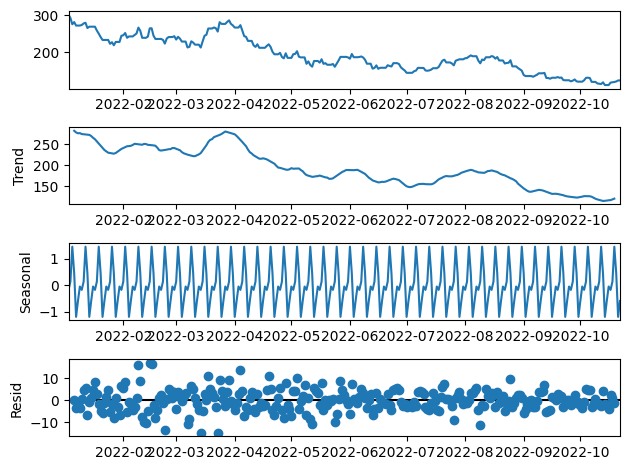

In [286]:
# Copy data
df_copy = df[['Close']].copy()

# Decomposing dataset with multiplicative seasonality
decomposed = stats.tsa.seasonal.seasonal_decompose(df_copy.asfreq("D"), model = "additive")
plot1 = decomposed.plot()

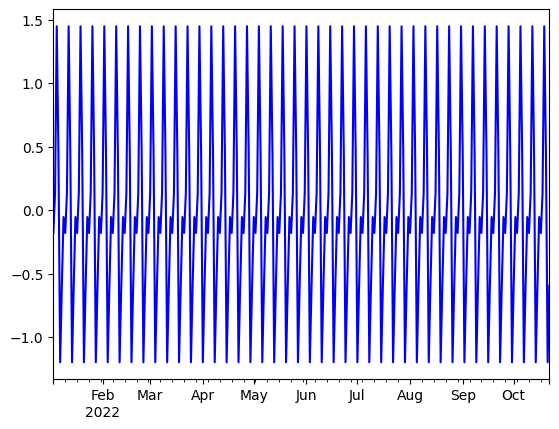

In [287]:
# Plot seasonality
plot2 = decomposed.seasonal.plot(color = 'blue')

There is a definite downward trend within the time series, in addition, it seems that there might be some seasonality within the data, but with very little magnitude.

In [288]:
is_stationary(df, "Close")

p-value: 0.34577908393339885

Is stationary: False


The p-value returned is greater than 0.05, hence there is insufficient evidence to reject the null hypothesis that the data is not stationary.

In [289]:
# Apply first level differencing on model data
DE_df = df.copy()
DE_df['diff1'] = df['Close'].diff()

# Drop missing values from differencing
DE_df.dropna(axis = 0, inplace = True)
DE_df.head()

,Open,High,Low,Close,Adj Close,Volume,diff1
2022-01-04,302.769989,304.679993,283.489990,292.899994,292.701202,52715400.0,-8.309998
2022-01-05,289.489990,294.160004,275.329987,276.040009,275.852661,49806400.0,-16.859985
2022-01-06,276.399994,284.380005,270.649994,281.779999,281.588745,45418600.0,5.739990
2022-01-07,281.410004,284.220001,270.570007,272.470001,272.285095,40993900.0,-9.309998
2022-01-08,281.410004,284.220001,270.570007,272.470001,272.285095,40993900.0,0.000000


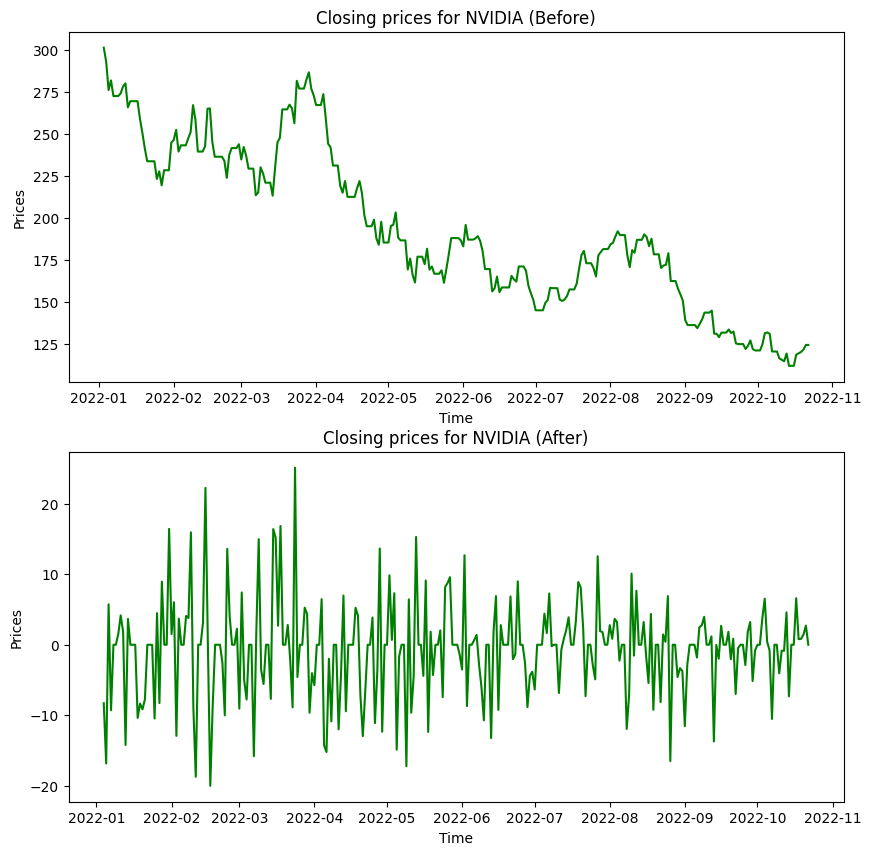

In [290]:
# Plot differenced data against original data.
plt.figure(figsize = (10, 10))
plt.subplot(2,1,1)
plt.plot(df['Close'], color = 'green')
plt.xlabel("Time")
plt.ylabel("Prices")
plt.title("Closing prices for NVIDIA (Before)")

plt.subplot(2,1,2)
plt.plot(DE_df['diff1'], color = 'green')
plt.xlabel("Time")
plt.ylabel("Prices")
plt.title("Closing prices for NVIDIA (After)")
plt.show()

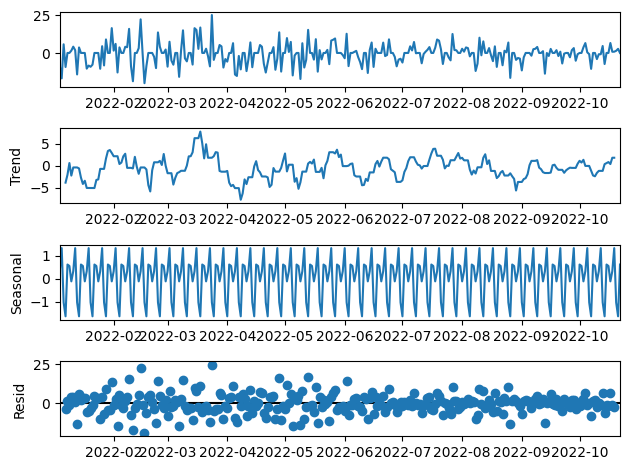

In [291]:
# Decomposing differenced dataset with multiplicative seasonality
df_copy2 = DE_df[['diff1']].copy()
decomposed2 = stats.tsa.seasonal.seasonal_decompose(df_copy2.asfreq("D"), model = "additive")
plot2 = decomposed2.plot()

In [294]:
# Check if data is now stationary
is_stationary(DE_df, "diff1")

p-value: 1.763175857676872e-05

Is stationary: True


As the p-value is now below 0.05, we have sufficient evidence to reject the null hypothesis and the data is stationary after one round of differencing.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


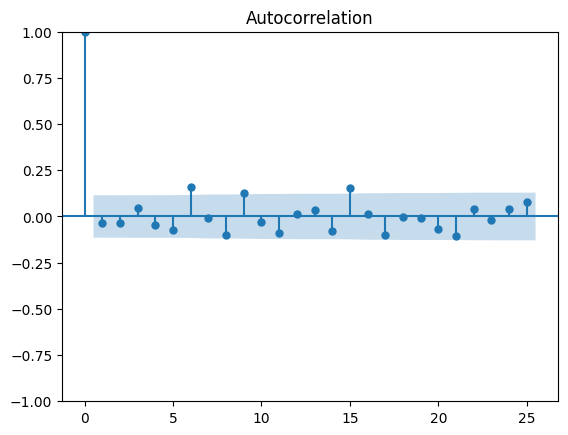

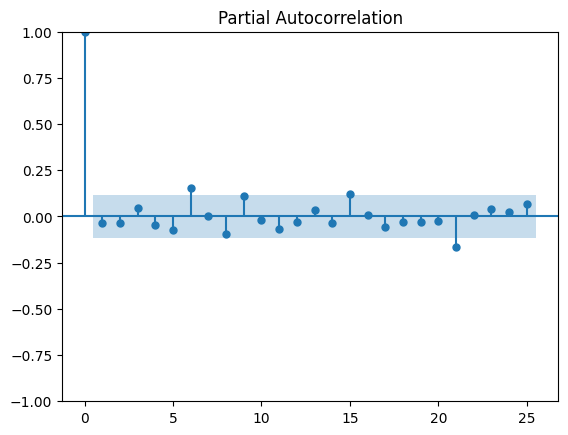

In [295]:
# Develop ACF & PACF plot
acf = stats.graphics.tsaplots.plot_acf(DE_df['diff1'])
pacf = stats.graphics.tsaplots.plot_pacf(DE_df['diff1'])

The plots above show that the model we should use is a ARIMA(0,1,0) model, which means there is no moving average or autoregressive portion and that the it is a random walk, which is reasonable, considering stock prices are random.

# Model Development

As the best model returned by the auto_arima model is a SARIMAX(2,1,2) x (0,0,0)^0, or a ARIMA(2,1,2) model, which contradicts what we discovered, that the best model should be ARIMA(0,1,0). We will be using the AutoARIMA generated model for our final predictions as the software could have possibly discovered a better model through it's own internal tests, looking at the stepwise search lists, the auto_arima has also considered a ARIMA(0,1,0) model within it's tests and yet returned a ARIMA(2,1,2) model as the better model.

In [296]:
# Using autoarima to develop the best possible model
model = pmd.auto_arima(
    df['Close'], trace = True, stationary = False, 
    
    # Set D = 1 to force auto arima to try to observe any possible seasonality.
    D = 1)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1932.958, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1939.871, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1941.492, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1941.463, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1940.269, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1944.849, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1944.729, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1934.554, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1934.562, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1943.324, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1946.637, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1946.333, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1936.943, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1933.637, Time=0.11 sec

Best model:  ARIMA(2,1,2)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  293
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -960.479
Date:                Sun, 23 Oct 2022   AIC                           1932.958
Time:                        17:54:31   BIC                           1955.019
Sample:                    01-03-2022   HQIC                          1941.795
                         - 10-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.6838      1.038     -1.622      0.105      -3.719       0.351
ar.L1         -0.8296      0.032    -25.817      0.000      -0.893      -0.767
ar.L2         -0.9679      0.033    -28.973      0.000      -1.033      -0.902
ma.L1          0.7848      0.052     15.080      0.000       0.683       0.887
ma.L2          0.9217      0.054     17.099      0.000       0.816       1.027
sigma2        42.0679      2.890     14.556      0.000      36.404      47.732
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                17.37
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [297]:
# Extract final 10 days to test our model predictions
df_test = df[-10:]
df_train = df[:-10]

In [298]:
# Fitting the model
model_res = model.fit(df_train['Close'])
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  283
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -932.487
Date:                Sun, 23 Oct 2022   AIC                           1876.974
Time:                        17:54:33   BIC                           1898.825
Sample:                    01-03-2022   HQIC                          1885.737
                         - 10-12-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.9064      1.361     -0.666      0.506      -3.575       1.762
ar.L1         -1.0381      0.013    -78.249      0.000      -1.064      -1.012
ar.L2         -0.9924      0.015    -67.007      0.000      -1.021      -0.963
ma.L1          1.0600      0.035     30.719      0.000       0.992       1.128
ma.L2          0.9832      0.051     19.443      0.000       0.884       1.082
sigma2        46.0185      3.507     13.121      0.000      39.145      52.892
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                25.00
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

With the exception of the intercept, we can see that all the coefficients have a p-value below 0.05, hence there is sufficient evidence to reject the null hypothesis, making them statistically significant predictors within the model.

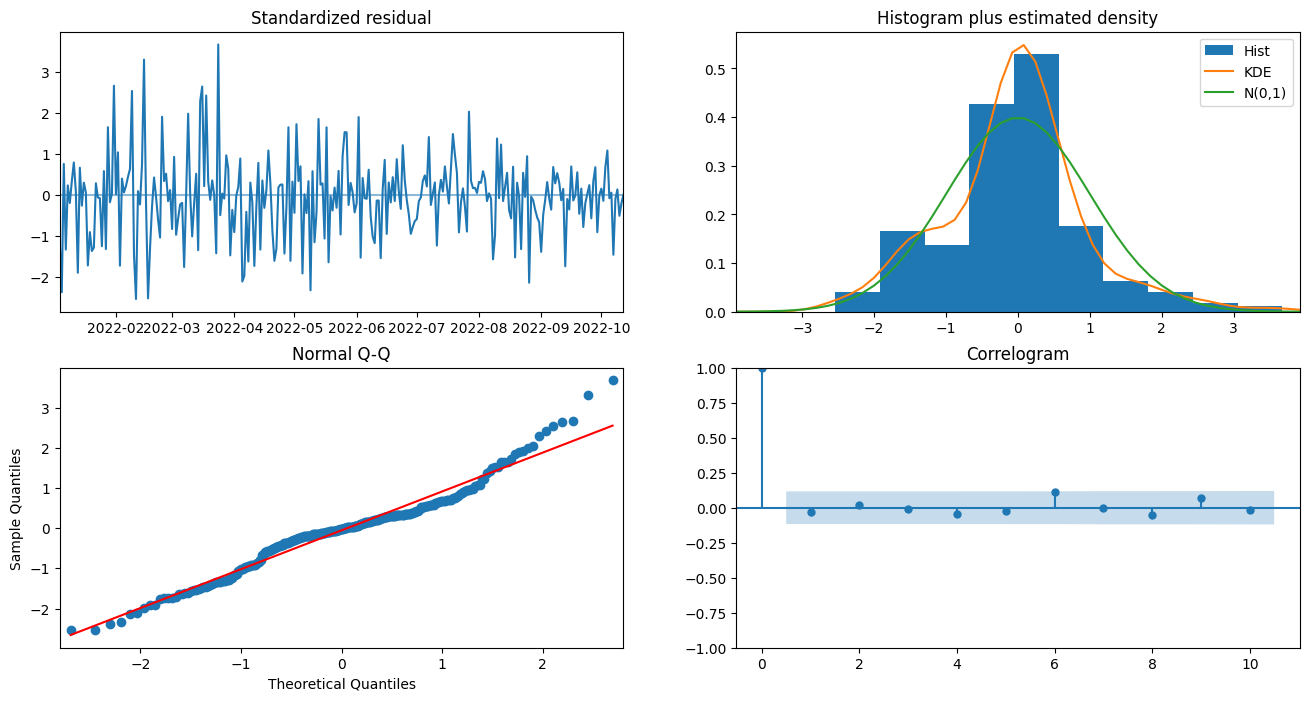

In [299]:
model_res.plot_diagnostics(figsize=(16, 8))
plt.show()

# Evaluation

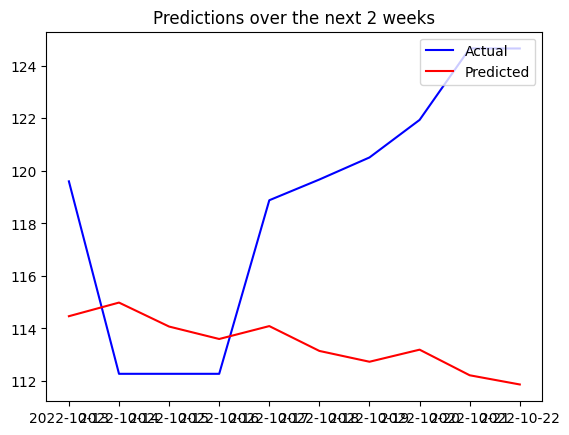

In [300]:
# Use model to calculate final predictions
final_pred = model_res.predict(10)

# Get confidence intervals
final_pred_ci = model_res.conf_int()

# Plot results
plt.plot(df_test['Close'], color = 'blue', label = 'Actual')
plt.plot(final_pred, label = 'Predicted', color = 'red')
plt.title('Predictions over the next 2 weeks')
plt.legend(loc = 'upper right')
plt.show()

In [301]:
# Get RMSE
df_rmse= df_test.copy()
df_rmse['Predictions'] = final_pred
RMSE = np.sqrt(((df_rmse['Predictions'] - df_rmse['Close']) ** 2).mean())
print('RMSE: {a}'.format(a = RMSE))

RMSE: 7.483812699885035


# Final Predictions

In [302]:
# Generate model predictions
model_final = model_res.fit(df['Close'])
final_predictions = model_final.predict(10)

In [303]:
# View predicted results
df_pred = pd.DataFrame(final_predictions, columns = ['Close'])

# Create the correct daterange for the predictions
range1 = pd.date_range("2022-10-24", "2022-10-28") 
range2 = pd.date_range("2022-10-31", "2022-11-04")

final_range = range1.union(range2)

# Reset index to correct dates
df_pred['Dates'] = final_range
df_pred.set_index('Dates')

,Close
Dates,
2022-10-24,124.193647
2022-10-25,123.314564
2022-10-26,122.811390
2022-10-27,122.395827
2022-10-28,121.543750
2022-10-31,120.969011
2022-11-01,120.586681
2022-11-02,119.776300
2022-11-03,119.134803


In [304]:
# Reformat and save data as a csv
df_pred = df_pred.reset_index(drop = True)
df_pred.drop('Dates', inplace = True, axis = 1)
df_pred.index.name = 'Index'
df_pred.to_csv('Yeo_Shu_Heng_Impl2.csv')